<a href="https://colab.research.google.com/github/Abdus-Salam24/Thesis_or_Project/blob/main/Deep_learning_for_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Create a fully-documented, Colab-ready deep learning notebook as an .ipynb file.
import nbformat as nbf
from pathlib import Path

nb = nbf.v4.new_notebook()

cells = []

# 0) Title and overview
"""
# Colab Notebook: CNN Deep Learning Model on MNIST (TensorFlow/Keras)

This notebook builds, trains, evaluates, and saves a **Convolutional Neural Network (CNN)** for **MNIST handwritten digit classification**.
It is 100% **Colab-ready** and includes steps to **save everything into your Google Drive sub-directory**.

## What I'll do
1. Setup & GPU check
2. Mount Google Drive and create a **sub-directory** for submission
3. Load & preprocess MNIST data
4. Build a CNN model (with BatchNorm & Dropout)
5. Train with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
6. Evaluate (metrics + confusion matrix)
7. Save artifacts (model, plots, metrics) into your **sub-directory**
8. (Optional) Export a zipped submission folder

> **Tip:** In Colab, go to **Runtime → Change runtime type → GPU** for faster training.
"""


"\n# Colab Notebook: CNN Deep Learning Model on MNIST (TensorFlow/Keras)\n\nThis notebook builds, trains, evaluates, and saves a **Convolutional Neural Network (CNN)** for **MNIST handwritten digit classification**.\nIt is 100% **Colab-ready** and includes steps to **save everything into your Google Drive sub-directory**.\n\n## What you'll do\n1. Setup & GPU check\n2. Mount Google Drive and create a **sub-directory** for submission\n3. Load & preprocess MNIST data\n4. Build a CNN model (with BatchNorm & Dropout)\n5. Train with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)\n6. Evaluate (metrics + confusion matrix)\n7. Save artifacts (model, plots, metrics) into your **sub-directory**\n8. (Optional) Export a zipped submission folder\n\n> **Tip:** In Colab, go to **Runtime → Change runtime type → GPU** for faster training.\n"

#1.Setup: Versions & GPU check

In [3]:

#@title  Setup: Versions & GPU check
import os, random, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from platform import python_version

print("Python:", python_version())
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



Python: 3.12.11
TensorFlow: 2.19.0
NumPy: 2.0.2
GPUs available: []


#2.Mount Drive and create directories

In [5]:
#@title  Mount Google Drive & Choose sub-directory
from google.colab import drive
drive.mount('/content/drive')

#@markdown **Edit these as needed:**
BASE_DIR = "/content/drive/MyDrive" #@param {type:"string"}
PROJECT_FOLDER_NAME = "dl_submission_mnist" #@param {type:"string"}
PROJECT_DIR = f"{BASE_DIR}/{PROJECT_FOLDER_NAME}"
os.makedirs(PROJECT_DIR, exist_ok=True)

print("Project directory:", PROJECT_DIR)

Mounted at /content/drive
Project directory: /content/drive/MyDrive/dl_submission_mnist


# 3.Load & preprocess data

In [7]:
#@title  Load & Preprocess MNIST
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0,1] and add channel dim
x_train = (x_train / 255.0).astype("float32")[..., None]
x_test  = (x_test  / 255.0).astype("float32")[..., None]

# One-hot labels
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# Train/Val split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train_cat, y_val_cat = train_test_split(
    x_train, y_train_cat, test_size=0.1, random_state=SEED, stratify=y_train)

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (54000, 28, 28, 1) Val: (6000, 28, 28, 1) Test: (10000, 28, 28, 1)


# 4.Visualize samples

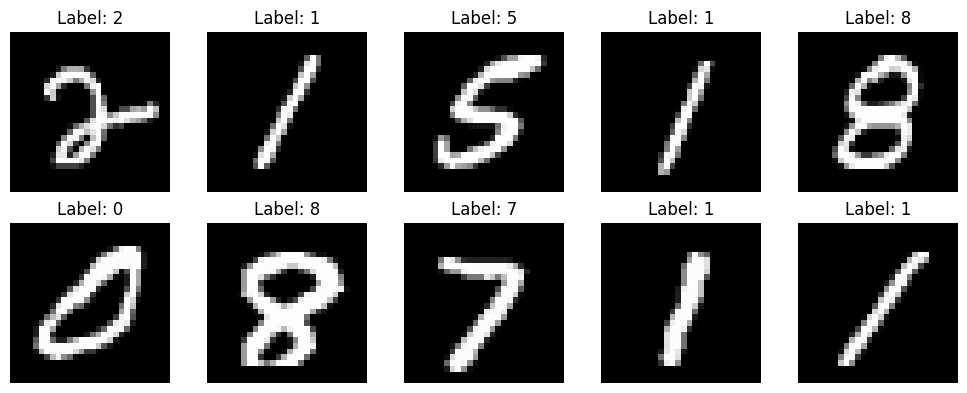

In [8]:
#@title  Visualize a few samples
fig, axes = plt.subplots(2, 5, figsize=(10,4))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {np.argmax(y_train_cat[i])}")
    axes[i].axis("off")
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/samples_preview.png", dpi=150)
plt.show()

# 5.Build model

In [9]:
#@title Build a CNN model (Keras)
from tensorflow.keras import layers, models

def build_cnn(input_shape=(28,28,1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding="same", activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

model = build_cnn()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

# 6.Train model with callbacks

In [11]:
#@title Train with callbacks (EarlyStopping, ReduceLROnPlateau, Checkpoint)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt_path = f"{PROJECT_DIR}/best_model.keras"
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_val, y_val_cat),
    epochs=20,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Save final model
final_model_path = f"{PROJECT_DIR}/final_model.keras"
model.save(final_model_path)
print("Saved:", ckpt_path, "and", final_model_path)

Epoch 1/20
 12/422 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.9777 - loss: 0.0756

KeyboardInterrupt: 

# 7.Plot training curves

In [12]:
#@title Plot training curves
def plot_history(hist, key="accuracy"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(hist.history[key], label=f"train_{key}")
    plt.plot(hist.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch")
    plt.ylabel(key.capitalize())
    plt.legend()
    out_path = f"{PROJECT_DIR}/history_{key}.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved", out_path)

plot_history(history, "accuracy")
plot_history(history, "loss")

NameError: name 'history' is not defined

# 8.Evaluate and confusion matrix

Test Accuracy: 0.9633 | Test Loss: 0.1161
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.94      0.99      0.97       980
           1       1.00      0.96      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.99      0.98      0.98      1010
           4       1.00      0.92      0.96       982
           5       0.95      0.99      0.97       892
           6       0.93      0.99      0.96       958
           7       1.00      0.93      0.96      1028
           8       0.90      1.00      0.94       974
           9       0.97      0.91      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



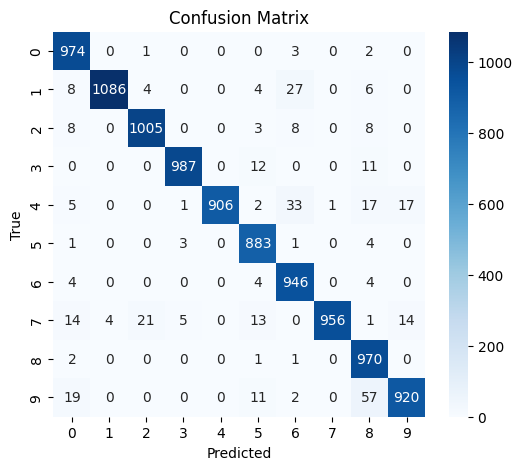

Saved /content/drive/MyDrive/dl_submission_mnist/confusion_matrix.png


In [13]:
#@title Evaluation & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)
print("\\nClassification Report:\\n", classification_report(y_test, y_pred))

# Confusion matrix plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
cm_path = f"{PROJECT_DIR}/confusion_matrix.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved", cm_path)

# Save metrics
with open(f"{PROJECT_DIR}/metrics.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\\nTest Loss: {test_loss:.4f}\\n")


# 9.Inference demo

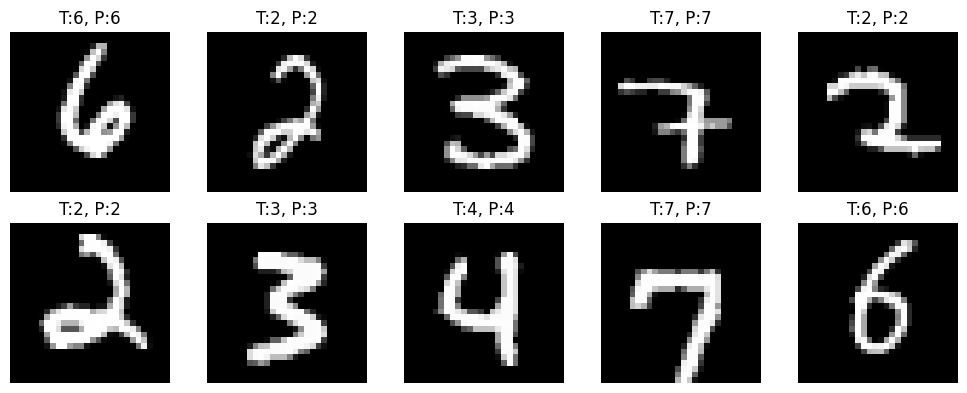

In [14]:
#@title Inference demo on 10 random test images
idx = np.random.choice(len(x_test), size=10, replace=False)
imgs, labels = x_test[idx], y_test[idx]
preds = np.argmax(model.predict(imgs, verbose=0), axis=1)

fig, axes = plt.subplots(2,5, figsize=(10,4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i].squeeze(), cmap="gray")
    ax.set_title(f"T:{labels[i]}, P:{preds[i]}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/inference_preview.png", dpi=150)
plt.show()

# 10.Zip artifacts

In [15]:
#@title  (Optional) Zip your submission folder
!zip -r -q "{PROJECT_DIR}.zip" "{PROJECT_DIR}"
print("Zipped to:", f"{PROJECT_DIR}.zip")

Zipped to: /content/drive/MyDrive/dl_submission_mnist.zip
